In [1]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import catboost
from catboost import CatBoostClassifier

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score

In [2]:
## 파일 생성 및 경로
import os
from datetime import datetime

def file_make(filename):
    now = datetime.now()
    date =  now.strftime('%Y-%m-%d')

    file_path = './'+ filename +'/' + date
    os.makedirs(file_path,exist_ok=True)
    print(file_path)
    return file_path

In [30]:
import pandas as pd

trn_data = pd.read_csv('./data/2022-12-14/trn_data.csv')
tst_data = pd.read_csv('./data/2022-12-14/tst_data.csv')
sub = pd.read_csv('./data/sample_submission.csv')

In [31]:
def cat_to_num(df):
    df['class'] = df['class'].replace({'A':0,'B':1,'C':2})
    return df

def num_to_cat(df):
    df['class'] = df['class'].replace({0:'A',1:'B',2:'C'})
    return df

In [32]:
trn_data = cat_to_num(trn_data)

In [33]:
features = trn_data.drop(['id', 'class',],axis=1)
labels = trn_data['class']
X_train, X_test, y_train, y_test=train_test_split(features,labels,test_size=0.3,random_state=42)

In [34]:
import numpy as np
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    data, target = features,labels
    train_x, valid_x, train_y, valid_y = train_test_split(features,labels, test_size=0.3)


    param = {
        'objective': 'multi:softmax',
        'num_class' : [4],
        'eval_metric': 'mlogloss', # Multiclass logloss
        'lambda': trial.suggest_float('lambda', 0, 10.0),
        'alpha': trial.suggest_float('alpha', 0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1.0),
        'subsample': trial.suggest_float('subsample', 0.2,1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001,0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100,3000),
        'max_depth': trial.suggest_categorical('max_depth', [2,3,4,5,6,7,8,9,10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'num_parallel_tree': trial.suggest_int('num_parallel_tree',1,1),
    }


    xgb = XGBClassifier(**param)

    xgb.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = xgb.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

In [35]:
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-14 19:30:16,956] A new study created in memory with name: no-name-9ee9dde6-cba9-4b24-a784-f227bfab9e3e
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:861: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[I 2022-12-14 19:30:17,583] Trial 0 finished with value: 0.6582278481012658 and parameters: {'lambda': 1.5401875646088337, 'alpha': 9.86104432924106, 'colsample_bytree': 0.22150986289197516, 'subsample': 0.2677306677176876, 'learning_rate': 0.06628493583984972, 'n_estimators': 1223, 'max_depth': 7, 'min_child_weight': 9, 'num_parallel_tree': 1}. Best is trial 0 with value: 0.6582278481012658.
C:\Users\deepBlue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xg

Number of finished trials: 100
Best trial:
  Value: 1.0
  Params: 
    lambda: 1.4130230622576423
    alpha: 2.0456818223071425
    colsample_bytree: 0.9098382228702879
    subsample: 0.7050120457357982
    learning_rate: 0.08179819646106946
    n_estimators: 473
    max_depth: 9
    min_child_weight: 1
    num_parallel_tree: 1


In [36]:
from optuna import visualization
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
hist = study.trials_dataframe()
hist.head()

Best trial: score 1.0,
params {'lambda': 1.4130230622576423, 'alpha': 2.0456818223071425, 'colsample_bytree': 0.9098382228702879, 'subsample': 0.7050120457357982, 'learning_rate': 0.08179819646106946, 'n_estimators': 473, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1}


,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_n_estimators,params_num_parallel_tree,params_subsample,state
0,0,0.658228,2022-12-14 19:30:16.957342,2022-12-14 19:30:17.583443,0 days 00:00:00.626101,9.861044,0.221510,1.540188,0.066285,7,9,1223,1,0.267731,COMPLETE
1,1,0.924051,2022-12-14 19:30:17.584445,2022-12-14 19:30:18.788806,0 days 00:00:01.204361,3.542249,0.351606,9.281585,0.088011,8,8,1979,1,0.476163,COMPLETE
2,2,0.949367,2022-12-14 19:30:18.790811,2022-12-14 19:30:20.062123,0 days 00:00:01.271312,3.203052,0.448516,4.815356,0.048302,4,9,1826,1,0.606833,COMPLETE
3,3,0.974684,2022-12-14 19:30:20.063260,2022-12-14 19:30:21.314519,0 days 00:00:01.251259,5.683890,0.654873,8.869532,0.095190,8,7,2024,1,0.888157,COMPLETE
4,4,0.936709,2022-12-14 19:30:21.315521,2022-12-14 19:30:21.565120,0 days 00:00:00.249599,9.182837,0.682793,9.225080,0.044030,9,9,229,1,0.773277,COMPLETE


In [20]:
# optuna.visualization.plot_slice(study)

In [23]:
# optuna.visualization.plot_optimization_history(study)

In [37]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [num_parallel_tree (IntDistribution):
                                0.0<extra></extra>, n_estimators (IntDistribution):
                                0.008822240717505245<extra></extra>, lambda
                                (FloatDistribution):
                                0.014275424991033443<extra></extra>, subsample
                                (FloatDistribution):
                                0.01704249301285241<extra></extra>, max_depth
                                (CategoricalDistribution):
                                0.027018020842648954<extra></extra>,
                                min_child_weight (IntDistribution):
                                0.031213685231616876<extra></extra>, learning_rate
                                (FloatDistribution):
                                0.11776194412341731<extra></extra>, alpha
                                (FloatDistribution):
                                0.2730108798426433<extra></extra>, colsample_bytree
                                (FloatDistribution):
                                0.5108553112382826<extra></extra>],
              'marker': {'color': 'rgb(66,146,198)'},
              'orientation': 'h',
              'text': [<0.01, <0.01, 0.01, 0.02, 0.03, 0.03, 0.12, 0.27, 0.51],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.0, 0.008822240717505245, 0.014275424991033443,
                    0.01704249301285241, 0.027018020842648954,
                    0.031213685231616876, 0.11776194412341731, 0.2730108798426433,
                    0.5108553112382826],
              'y': [num_parallel_tree, n_estimators, lambda, subsample, max_depth,
                    min_child_weight, learning_rate, alpha, colsample_bytree]}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Importance for Objective Value'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [38]:
# 'lambda': 1.4130230622576423, 'alpha': 2.0456818223071425, 'colsample_bytree': 0.9098382228702879, 
# 'subsample': 0.7050120457357982, 'learning_rate': 0.08179819646106946, 
# 'n_estimators': 473, 'max_depth': 9, 'min_child_weight': 1, 'num_parallel_tree': 1

clf=XGBClassifier()
parametres={'lambda': [1.4130230622576423], 'alpha': [2.0456818223071425], 'colsample_bytree': [0.9098382228702879],
'subsample': [0.7050120457357982], 'learning_rate': [0.08179819646106946], 'n_estimators': [473],
'max_depth': [9], 'min_child_weight': [1], 'num_parallel_tree': [1]}
grid_search_cv_clf=GridSearchCV(clf,parametres,cv=5)
grid_search_cv_clf.fit(X_train,y_train)
best_clf2=grid_search_cv_clf.best_estimator_
y_pred2=best_clf2.predict(X_test)
print(f'Accuracy_score: {accuracy_score(y_test,y_pred2)}')

Accuracy_score: 0.9620253164556962


In [39]:
# 모델 저장
import joblib
model_path = file_make('model') + '/XGBboost02' +'.model'
best_clf2.save_model(model_path)
joblib.dump(best_clf2, open(model_path, 'wb'))

./model/2022-12-14


Text(0.5, 1.0, 'Feature Importance')

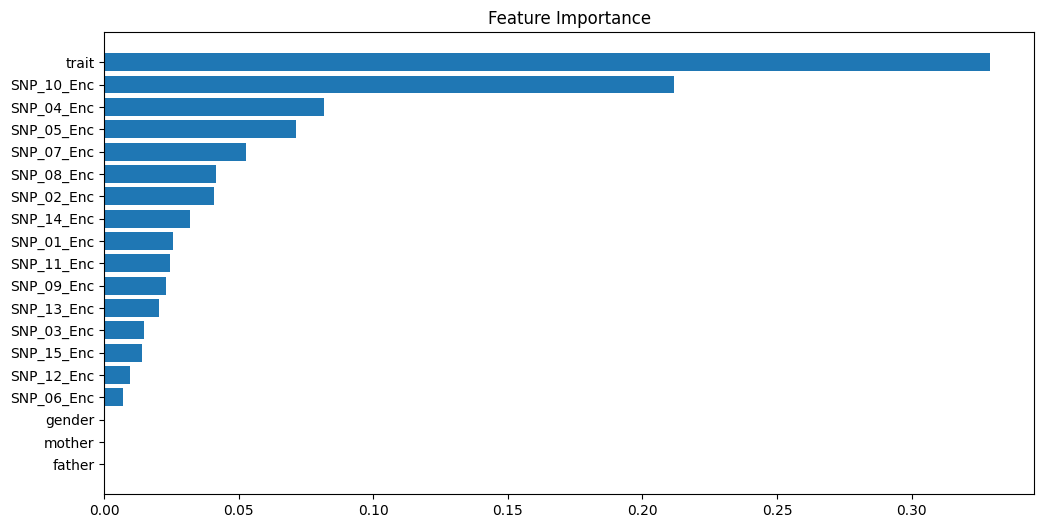

In [40]:
import matplotlib.pyplot as plt

feature_importance = best_clf2.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [41]:
test01 = tst_data.drop(['id', ],axis=1)
y_predicted=best_clf2.predict(test01)
tst_data['class'] = y_predicted

In [42]:
sub = pd.read_csv('./data/sample_submission.csv')
sub = sub.drop(['class'],axis=1)
submit = pd.merge(sub, tst_data[['id','class']], how='outer', on = 'id')
submit = num_to_cat(submit)

In [43]:
number = '02'
submit_path = file_make('submit_file') +'/submitionXGB' + number +'.csv'
submit.to_csv(submit_path,index=False)

./submit_file/2022-12-14


In [44]:
submit_check = pd.read_csv(submit_path)
submit_check

,id,class
0,TEST_000,A
1,TEST_001,B
2,TEST_002,C
3,TEST_003,B
4,TEST_004,A
...,...,...
170,TEST_170,B
171,TEST_171,C
172,TEST_172,C
173,TEST_173,B
